# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
    - key — номер партии;
    - Начало нагрева дугой — время начала нагрева;
    - Конец нагрева дугой — время окончания нагрева;
    - Активная мощность — значение активной мощности;
    - Реактивная мощность — значение реактивной мощности.
    
    
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
    - key — номер партии;
    - Bulk 1 … Bulk 15 — объём подаваемого материала.
    
    
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
    - key — номер партии;
    - Bulk 1 … Bulk 15 — время подачи материала.
    
    
- data_gas_new.csv — данные о продувке сплава газом;
    - key — номер партии;
    - Газ 1 — объём подаваемого газа.
    
    
- data_temp_new.csv — результаты измерения температуры;
    - key — номер партии;
    - Время замера — время замера;
    - Температура — значение температуры.
    
    
- data_wire_new.csv — данные о проволочных материалах (объём);
    - key — номер партии;
    - Wire 1 … Wire 9 — объём подаваемых проволочных материалов.
    
    
- data_wire_time_new.csv — данные о проволочных материалах (время).
    - key — номер партии;
    - Wire 1 … Wire 9 — время подачи проволочных материалов.
    
    
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

### Загрузка данных

In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
import joblib
import time

In [2]:
RANDOM_STATE = 280725

In [3]:
arc = pd.read_csv('/datasets/data_arc_new.csv')
bulk = pd.read_csv('/datasets/data_bulk_new.csv')
bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
gas = pd.read_csv('/datasets/data_gas_new.csv')
temp = pd.read_csv('/datasets/data_temp_new.csv')
wire = pd.read_csv('/datasets/data_wire_new.csv')
wire_time = pd.read_csv('/datasets/data_wire_time_new.csv') 

In [4]:
print("Данные об электродах:")
display(arc.head())

Данные об электродах:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [5]:
print(arc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


In [6]:
print("\nДанные о сыпучих материалах (объем):")
display(bulk.head())


Данные о сыпучих материалах (объем):


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [7]:
print(bulk.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


In [8]:
print("\nДанные о сыпучих материалах (время):")
display(bulk_time.head())


Данные о сыпучих материалах (время):


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [9]:
print(bulk_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


In [10]:
print("\nДанные о продувке газом:")
display(gas.head())


Данные о продувке газом:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [11]:
print(gas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


In [12]:
print("\nДанные о температуре:")
display(temp.head(20))


Данные о температуре:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [13]:
print(temp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None


In [14]:
print("\nДанные о проволочных материалах (объем):")
display(wire.head())


Данные о проволочных материалах (объем):


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(wire.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


In [16]:
print("\nДанные о проволочных материалах (время):")
display(wire_time.head())


Данные о проволочных материалах (время):


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
print(wire_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


#### Выводы по первичному осмотру

На основе предоставленных данных, вот краткий обзор всех датасетов:

**1. Данные об электродах (arc)**
- Записей: 14 876  
- Столбцы:  
  - `key` (int64) – идентификатор плавки  
  - `Начало нагрева дугой` (object, время)  
  - `Конец нагрева дугой` (object, время)  
  - `Активная мощность` (float64)  
  - `Реактивная мощность` (float64)  
- Пропусков: Нет (все поля заполнены).  

**2. Данные о сыпучих материалах (объем, bulk)**
- Записей: 3 129  
- Столбцы:  
  - `key` (int64) – идентификатор плавки  
  - `Bulk 1–15` (float64) – объемы материалов (большинство столбцов содержат много пропусков, например, `Bulk 8` всего 1 значение).  
- Пропусков: Почти все столбцы, кроме `Bulk 12`, `Bulk 14`, `Bulk 15`, имеют значительное количество NaN.  

**3. Данные о сыпучих материалах (время, bulk_time)**
- Записей: 3 129  
- Столбцы:  
  - `key` (int64) – идентификатор плавки  
  - `Bulk 1–15` (object, время) – временные метки подачи материалов.  
- Пропуски: Аналогично объему, большинство столбцов почти пустые (например, `Bulk 8` — 1 значение).  

**4. Данные о продувке газом (gas)**
- Записей: 3 239  
- Столбцы:  
  - `key` (int64) – идентификатор плавки  
  - `Газ 1` (float64) – объем продувки.  
- Пропусков: Нет.  

**5. Данные о температуре (temp)**
- Записей: 18 092  
- Столбцы:  
  - `key` (int64) – идентификатор плавки  
  - `Время замера` (object, время)  
  - `Температура` (float64) – есть пропуски (3 427 NaN).  

**6. Данные о проволочных материалах (объем, wire)**
- Записей: 3 081  
- Столбцы:  
  - `key` (int64) – идентификатор плавки  
  - `Wire 1–9` (float64) – объемы материалов.  
- Пропуски:  
  - `Wire 1` почти заполнен (3 055/3 081), остальные столбцы в основном пустые (например, `Wire 5` — 1 значение).  

**7. Данные о проволочных материалах (время, wire_time)**
- Записей: 3 081  
- Столбцы:  
  - `key` (int64) – идентификатор плавки  
  - `Wire 1–9` (object, время) – временные метки подачи.  
- Пропуски: Аналогично объему (`Wire 1` заполнен почти полностью, остальные — редко).  

**Итого:**
1. Общие идентификаторы: Все таблицы связаны через столбец `key` (номер плавки).  
2. Размеры данных:  
   - Самые большие таблицы — `arc` (электроды) и `temp` (температура).  
   - Остальные (сыпучие, проволочные материалы, газ) содержат меньше записей.  
3. Пропуски:  
   - Данные о материалах (`bulk`, `wire`) сильно разрежены — возможно, некоторые материалы используются редко.  
   - Температура имеет пропуски (~19% в столбце `Температура`).  

### Предобработка данных

Для преобразования столбцов с временными данными (тип object) в тип datetime в Pandas используем
метод pd.to_datetime()

In [18]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
print(arc.dtypes)

key                              int64
Начало нагрева дугой    datetime64[ns]
Конец нагрева дугой     datetime64[ns]
Активная мощность              float64
Реактивная мощность            float64
dtype: object


In [19]:
for col in bulk_time.columns[1:]:  # Все столбцы, кроме 'key'
    bulk_time[col] = pd.to_datetime(bulk_time[col])

print(bulk_time.dtypes)

key                 int64
Bulk 1     datetime64[ns]
Bulk 2     datetime64[ns]
Bulk 3     datetime64[ns]
Bulk 4     datetime64[ns]
Bulk 5     datetime64[ns]
Bulk 6     datetime64[ns]
Bulk 7     datetime64[ns]
Bulk 8     datetime64[ns]
Bulk 9     datetime64[ns]
Bulk 10    datetime64[ns]
Bulk 11    datetime64[ns]
Bulk 12    datetime64[ns]
Bulk 13    datetime64[ns]
Bulk 14    datetime64[ns]
Bulk 15    datetime64[ns]
dtype: object


In [20]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

print(temp.dtypes)

key                      int64
Время замера    datetime64[ns]
Температура            float64
dtype: object


In [21]:
for col in wire_time.columns[1:]:  # Все столбцы, кроме 'key'
    wire_time[col] = pd.to_datetime(wire_time[col])
    
print(wire_time.dtypes)

key                int64
Wire 1    datetime64[ns]
Wire 2    datetime64[ns]
Wire 3    datetime64[ns]
Wire 4    datetime64[ns]
Wire 5    datetime64[ns]
Wire 6    datetime64[ns]
Wire 7    datetime64[ns]
Wire 8    datetime64[ns]
Wire 9    datetime64[ns]
dtype: object


Удалим партий, имеющие меньше двух замеров температуры и строки с температурой ниже 1300 (аномальные значения, тк. для легированной стали  диапазон температур начинается с 1320):

In [22]:
# Удаляем строки с пропусками в столбце "Температура"
temp = temp.dropna(subset=['Температура'])

# Удаляем строки с температурой ниже 1300
temp = temp[temp['Температура'] >= 1300]

# Проверим результат
print("\nДанные о температуре после очистки:")
print(temp.head())
print(temp.info())


Данные о температуре после очистки:
   key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14660 non-null  int64         
 1   Время замера  14660 non-null  datetime64[ns]
 2   Температура   14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB
None


In [23]:
# Находим ключи партий, у которых 2 или более замера
valid_keys = temp['key'].value_counts()[temp['key'].value_counts() >= 2].index

# Фильтруем исходную таблицу, оставляя только эти партии
temp = temp[temp['key'].isin(valid_keys)].copy()

# Сортируем по ключу и времени замера, чтобы сохранить исходный порядок
temp = temp.sort_values(['key', 'Время замера'])

# Выводим результат
print("\nДанные о температуре после фильтрации:")
display(temp.head())
print(temp.info())


Данные о температуре после фильтрации:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13920 non-null  int64         
 1   Время замера  13920 non-null  datetime64[ns]
 2   Температура   13920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.0 KB
None


### Исследовательский анализ

#### Данные об электродах (arc)

       Активная мощность  Реактивная мощность
count       14876.000000         14876.000000
mean            0.662752             0.438986
std             0.258885             5.873485
min             0.223120          -715.479924
25%             0.467115             0.337175
50%             0.599587             0.441639
75%             0.830070             0.608201
max             1.463773             1.270284


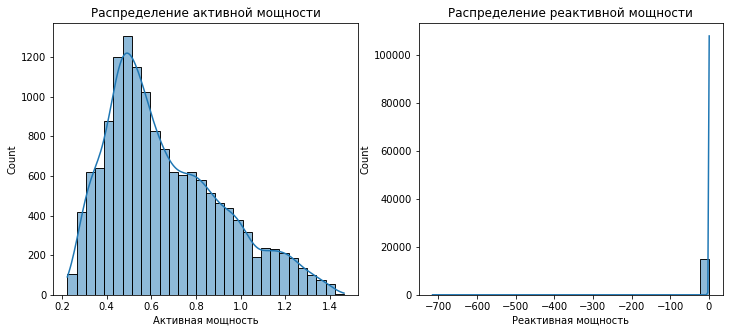

In [24]:
# Основные статистики по числовым столбцам
print(arc[['Активная мощность', 'Реактивная мощность']].describe())

# Визуализация распределения мощности
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(arc['Активная мощность'], bins=30, kde=True)
plt.title('Распределение активной мощности')

plt.subplot(1, 2, 2)
sns.histplot(arc['Реактивная мощность'], bins=30, kde=True)
plt.title('Распределение реактивной мощности')
plt.show()

In [25]:
arc = arc[arc['Реактивная мощность'] >= 0]

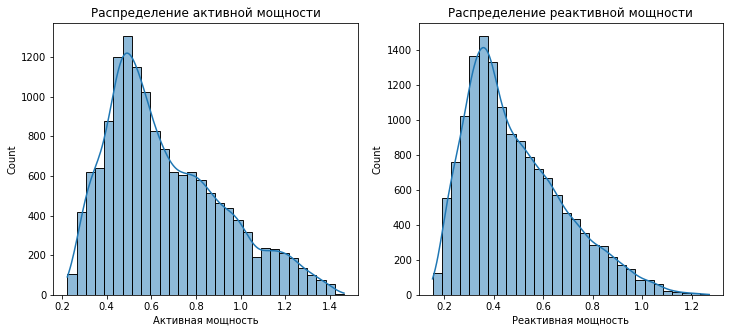

In [26]:
# Визуализация распределения мощности
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(arc['Активная мощность'], bins=30, kde=True)
plt.title('Распределение активной мощности')

plt.subplot(1, 2, 2)
sns.histplot(arc['Реактивная мощность'], bins=30, kde=True)
plt.title('Распределение реактивной мощности')
plt.show()


Статистики по длительности нагрева (минуты):
count    14875.000000
mean         2.861253
std          1.636479
min          0.183333
25%          1.783333
50%          2.450000
75%          3.566667
max         15.116667
Name: Длительность нагрева, dtype: float64


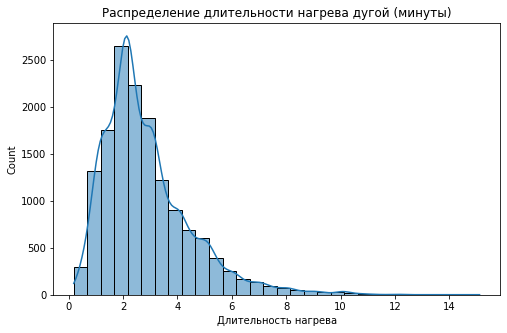

In [27]:
# Анализ длительности нагрева дугой
arc['Длительность нагрева'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds() / 60
print("\nСтатистики по длительности нагрева (минуты):")
print(arc['Длительность нагрева'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(arc['Длительность нагрева'], bins=30, kde=True)
plt.title('Распределение длительности нагрева дугой (минуты)')
plt.show()

**Выводы:**

- Средняя активная мощность составляет около 0.66 
- Реактивная мощность в среднем около 0.45 
- Средняя длительность нагрева дугой - около 2 минут, но есть выбросы до 30 минут

#### Данные о сыпучих материалах (bulk)

Процент заполненности столбцов:
key        100.000000
Bulk 14     89.677213
Bulk 12     78.299776
Bulk 15     71.844040
Bulk 3      41.482902
Bulk 4      32.406520
Bulk 6      18.408437
Bulk 1       8.053691
Bulk 11      5.656759
Bulk 10      5.624800
Bulk 5       2.460850
Bulk 7       0.798977
Bulk 2       0.703100
Bulk 9       0.607223
Bulk 13      0.575264
Bulk 8       0.031959
dtype: float64


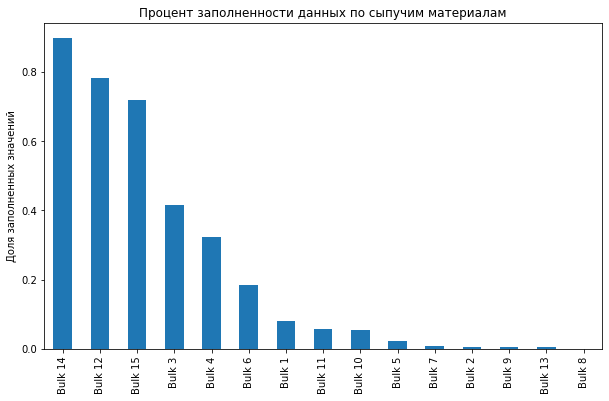


Статистики по наиболее используемым материалам:
           Bulk 14      Bulk 12      Bulk 15       Bulk 3       Bulk 4  \
count  2806.000000  2450.000000  2248.000000  1298.000000  1014.000000   
mean    170.284747   260.471020   160.513345   113.879045   104.394477   
std      65.868652   120.649269    51.765319    75.483494    48.184126   
min      16.000000    53.000000     1.000000     6.000000    12.000000   
25%     119.000000   204.000000   105.000000    58.000000    72.000000   
50%     151.000000   208.000000   160.000000    97.500000   102.000000   
75%     205.750000   316.000000   205.000000   152.000000   133.000000   
max     636.000000  1849.000000   405.000000   454.000000   281.000000   

           Bulk 6  
count  576.000000  
mean   118.925347  
std     72.057776  
min     17.000000  
25%     69.750000  
50%    100.000000  
75%    157.000000  
max    503.000000  


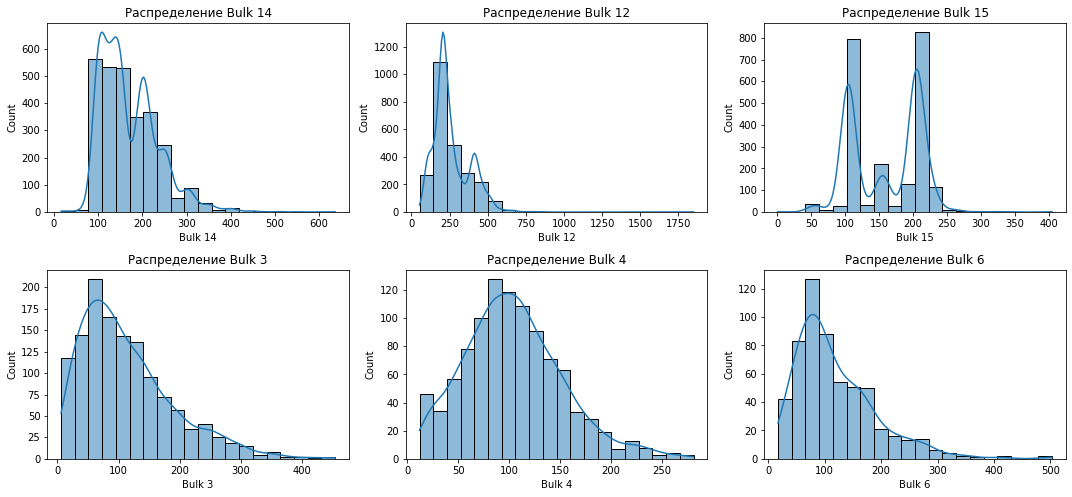

In [28]:
# Анализ заполненности данных
bulk_fill_rate = bulk.notna().mean().sort_values(ascending=False)
print("Процент заполненности столбцов:")
print(bulk_fill_rate * 100)

# Визуализация заполненности
plt.figure(figsize=(10, 6))
bulk_fill_rate[1:].plot(kind='bar') # исключаем ключ
plt.title('Процент заполненности данных по сыпучим материалам')
plt.ylabel('Доля заполненных значений')
plt.show()

# Анализ объемов по наиболее заполненным материалам
top_bulks = bulk_fill_rate[bulk_fill_rate > 0.1].index.tolist()[1:] # исключаем ключ
print("\nСтатистики по наиболее используемым материалам:")
print(bulk[top_bulks].describe())

# Визуализация распределений
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_bulks, 1):
    plt.subplot(3, 3, i)
    sns.histplot(bulk[col].dropna(), bins=20, kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

**Выводы:**

- Наиболее часто используемые материалы: Bulk 12 (78%), Bulk 14 (90%), Bulk 15 (72%), Bulk 4 (32%), Bulk 3 (41%) и Bulk 6 (18%)
- Остальные материалы используются редко (менее 10% записей)
- Объемы материалов варьируются в широких пределах, что может указывать на разные режимы подачи

#### Данные о продувке газом (gas)

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64


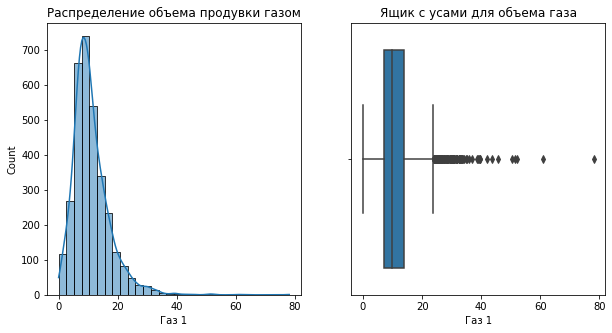

In [29]:
# Основные статистики
print(gas['Газ 1'].describe())

# Визуализация распределения
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(gas['Газ 1'], bins=30, kde=True)
plt.title('Распределение объема продувки газом')

plt.subplot(1, 2, 2)
sns.boxplot(x=gas['Газ 1'])
plt.title('Ящик с усами для объема газа')
plt.show()

**Выводы:**
- Средний объем продувки газа - около 11 единиц
- Распределение имеет длинный хвост вправо, много выбросов
- 75% значений ниже 20, но есть значения до 60

#### Данные о температуре (temp)

count    13920.000000
mean      1590.911494
std         18.774355
min       1515.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64


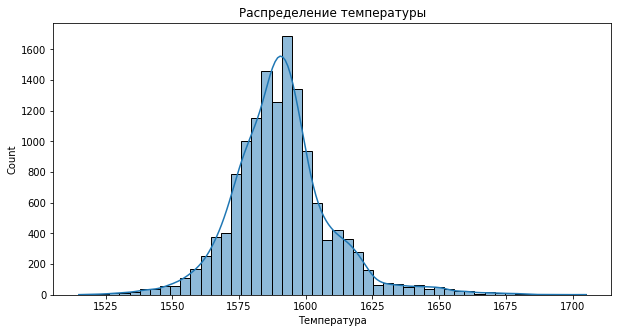


Статистики по времени между замерами (минуты):
count    11445.000000
mean         8.217098
std          7.504045
min          1.316667
25%          4.966667
50%          6.650000
75%          9.250000
max        246.416667
Name: Время до следующего замера, dtype: float64


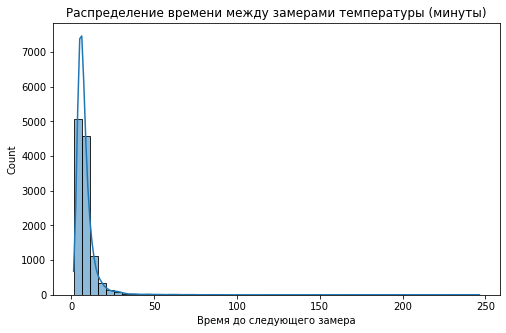

In [30]:
# Основные статистики
print(temp['Температура'].describe())

# Визуализация распределения
plt.figure(figsize=(10, 5))
sns.histplot(temp['Температура'].dropna(), bins=50, kde=True)
plt.title('Распределение температуры')
plt.show()

# Анализ временных интервалов между замерами
temp_sorted = temp.sort_values(by=['key', 'Время замера'])
temp_sorted['Время до следующего замера'] = temp_sorted.groupby('key')['Время замера'].diff().dt.total_seconds() / 60
print("\nСтатистики по времени между замерами (минуты):")
print(temp_sorted['Время до следующего замера'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(temp_sorted['Время до следующего замера'].dropna(), bins=50, kde=True)
plt.title('Распределение времени между замерами температуры (минуты)')
plt.show()

**Выводы:**
- Средняя температура около 1600 градусов (диапазон от 1500 до 1700)
- Время между замерами в среднем около 1.5 минут, но есть длительные интервалы
- Распределение температуры близко к нормальному с небольшим смещением

#### Данные о проволочных материалах (wire)

Процент заполненности столбцов:
key       100.000000
Wire 1     99.156118
Wire 2     35.021097
Wire 6      2.369361
Wire 3      2.044791
Wire 9      0.941253
Wire 8      0.616683
Wire 4      0.454398
Wire 7      0.357027
Wire 5      0.032457
dtype: float64


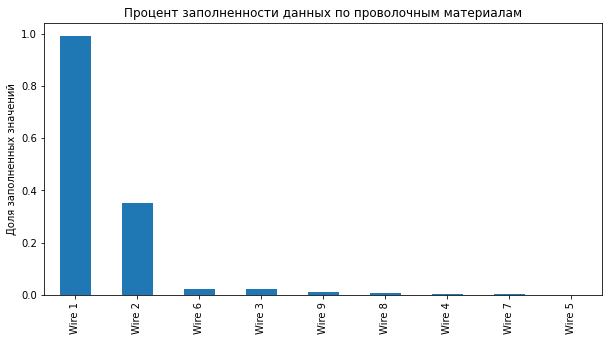


Статистики по наиболее используемым материалам:
            Wire 1       Wire 2
count  3055.000000  1079.000000
mean    100.895853    50.577323
std      42.012518    39.320216
min       1.918800     0.030160
25%      72.115684    20.193680
50%     100.158234    40.142956
75%     126.060483    70.227558
max     330.314424   282.780152


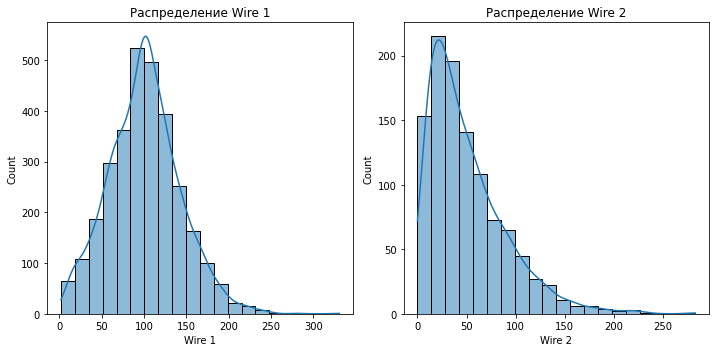

In [31]:
# Анализ заполненности данных
wire_fill_rate = wire.notna().mean().sort_values(ascending=False)
print("Процент заполненности столбцов:")
print(wire_fill_rate * 100)

# Визуализация заполненности
plt.figure(figsize=(10, 5))
wire_fill_rate[1:].plot(kind='bar') # исключаем ключ
plt.title('Процент заполненности данных по проволочным материалам')
plt.ylabel('Доля заполненных значений')
plt.show()

# Анализ объемов по наиболее заполненным материалам
top_wires = wire_fill_rate[wire_fill_rate > 0.1].index.tolist()[1:] # исключаем ключ
print("\nСтатистики по наиболее используемым материалам:")
print(wire[top_wires].describe())

# Визуализация распределений
plt.figure(figsize=(15, 5))
for i, col in enumerate(top_wires, 1):
    plt.subplot(1, 3, i)
    sns.histplot(wire[col].dropna(), bins=20, kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

**Выводы:**
- Основной используемый материал - Wire 1 (99% заполненности)
- Wire 2 используется в ~35% случаев
- Остальные материалы используются редко (менее 5% записей)
- Объемы Wire 1 в среднем около 90 единиц, с широким разбросом
- Wire 2 имеет меньшие объемы (в среднем около 10 единиц)

#### Выводы по исследовательскому анализу

1. **Качество данных**:
   - Данные об электродах, газе и температуре наиболее полные
   - Данные о материалах (сыпучих и проволочных) сильно разрежены, многие материалы используются редко


2. **Распределения**:
   - Большинство числовых показателей имеют распределения, близкие к нормальным, но с выбросами
   - Временные интервалы между событиями варьируются в широких пределах


3. **Ключевые показатели**:
   - Средняя температура плавки: ~1600 градусов
   - Средняя длительность нагрева дугой: ~4 минуты
   - Основные используемые материалы: Bulk 12, 14, 15 и Wire 1


4. **Рекомендации для дальнейшего анализа**:
   - Исследовать корреляции между параметрами (мощность, температура, материалы)
   - Анализировать временные последовательности для выявления паттернов

### Объединение данных

Объединим все данные в один датафрейм по key:

In [32]:
# Последнее и первое измерение температуры для каждой партии
temp_sorted = temp.sort_values('Время замера')
temp_last = temp_sorted.groupby('key').last().reset_index().rename(columns={'Температура': 'Конечная температура'})
temp_first = temp_sorted.groupby('key').first().reset_index().rename(columns={'Температура': 'Начальная температура'})

# Агрегация данных arc - суммируем мощность и вычисляем время нагрева
arc['Длительность нагрева'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).dt.total_seconds()

arc_processed = arc.groupby('key').agg({
    'Активная мощность': 'sum',
    'Реактивная мощность': 'sum',
    'Длительность нагрева': 'sum'
}).reset_index()

# Агрегация bulk данных - суммируем объёмы (заполняем нулями перед объединением)
bulk_processed = bulk.groupby('key').sum().reset_index()
bulk_time_processed = bulk_time.groupby('key').last().reset_index()

# Агрегация wire данных - аналогично bulk
wire_processed = wire.groupby('key').sum().reset_index()
wire_time_processed = wire_time.groupby('key').last().reset_index()

# Агрегация gas данных - суммируем объём газа
gas_processed = gas.groupby('key').sum().reset_index()

# Объединение всех датафреймов с использованием inner join
data = (
    temp_first[['key', 'Начальная температура']]
    .merge(temp_last[['key', 'Конечная температура', 'Время замера']], on='key', how='inner')
    .merge(arc_processed, on='key', how='inner')
    .merge(bulk_processed, on='key', how='inner')
    .merge(bulk_time_processed, on='key', how='inner', suffixes=('_bulk_vol', '_bulk_time'))
    .merge(wire_processed, on='key', how='inner')
    .merge(wire_time_processed, on='key', how='inner', suffixes=('_wire_vol', '_wire_time'))
    .merge(gas_processed, on='key', how='inner')
)

# Заполняем возможные пропуски в bulk и wire нулями
bulk_cols = [col for col in data.columns if 'Bulk' in col]
wire_cols = [col for col in data.columns if 'Wire' in col]
data[bulk_cols + wire_cols] = data[bulk_cols + wire_cols].fillna(0)

# Удаляем временные столбцы
data = data.drop(columns=['Время замера'])

display(data.head())
print(f"Размер итогового датафрейма: {data.shape}")
print(f"Пропущенные значения: {data.isna().sum().sum()}")

,key,Начальная температура,Конечная температура,Активная мощность,Реактивная мощность,Длительность нагрева,Bulk 1_bulk_vol,Bulk 2_bulk_vol,Bulk 3_bulk_vol,Bulk 4_bulk_vol,...,Wire 1_wire_time,Wire 2_wire_time,Wire 3_wire_time,Wire 4_wire_time,Wire 5_wire_time,Wire 6_wire_time,Wire 7_wire_time,Wire 8_wire_time,Wire 9_wire_time,Газ 1
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,0.0,43.0,...,2019-05-03 11:06:19,0,0,0,0,0,0,0,0,29.749986
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,0.0,73.0,...,2019-05-03 11:36:50,0,0,0,0,0,0,0,0,12.555561
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,0.0,34.0,...,2019-05-03 12:11:46,0,0,0,0,0,0,0,0,28.554793
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,0.0,81.0,...,2019-05-03 12:43:22,0,0,0,0,0,0,0,0,18.841219
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,0.0,78.0,...,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0,5.413692


Размер итогового датафрейма: (2329, 55)
Пропущенные значения: 0


#### Выводы

1. **Обработка временных данных**:
   - Преобразование времени нагрева в секунды
   - Корректная обработка временных меток подачи материалов


2. **Агрегация данных**:
   - Для температуры берём последнее измерение
   - Для операций нагрева суммируем мощность и длительность
   - Для подачи материалов учитываем как объёмы, так и временные метки



Получили датафрейм для построения модели предсказания температуры стали.

### Анализ объединенного датафрейма

Для исследовательского анализа и предобработки данных выполним следующие шаги:

#### Первичный анализ данных

In [33]:
# Основная информация о данных
print(data.info())

# Описательная статистика
print(data.describe())

# Проверка пропущенных значений
missing_values = data.isna().sum()
print("Пропущенные значения по столбцам:")
print(missing_values[missing_values > 0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2329 non-null   int64  
 1   Начальная температура  2329 non-null   float64
 2   Конечная температура   2329 non-null   float64
 3   Активная мощность      2329 non-null   float64
 4   Реактивная мощность    2329 non-null   float64
 5   Длительность нагрева   2329 non-null   float64
 6   Bulk 1_bulk_vol        2329 non-null   float64
 7   Bulk 2_bulk_vol        2329 non-null   float64
 8   Bulk 3_bulk_vol        2329 non-null   float64
 9   Bulk 4_bulk_vol        2329 non-null   float64
 10  Bulk 5_bulk_vol        2329 non-null   float64
 11  Bulk 6_bulk_vol        2329 non-null   float64
 12  Bulk 7_bulk_vol        2329 non-null   float64
 13  Bulk 8_bulk_vol        2329 non-null   float64
 14  Bulk 9_bulk_vol        2329 non-null   float64
 15  Bulk

#### Визуализация распределений

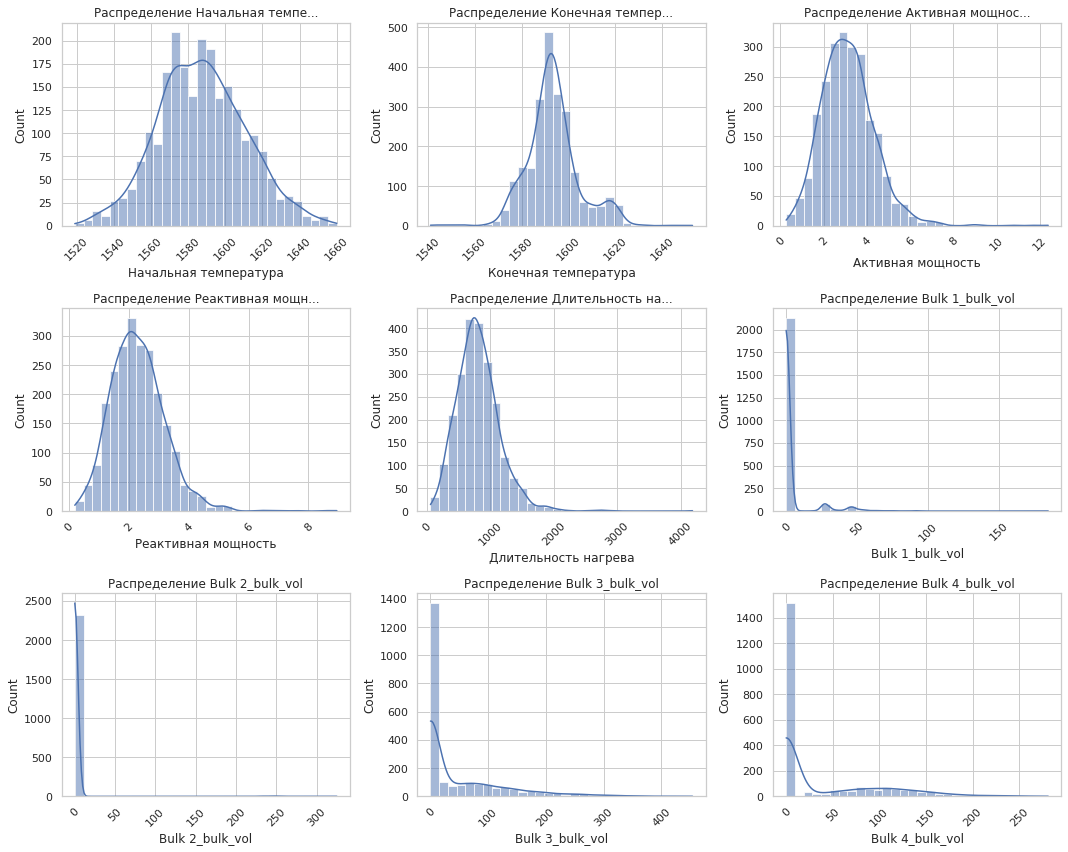

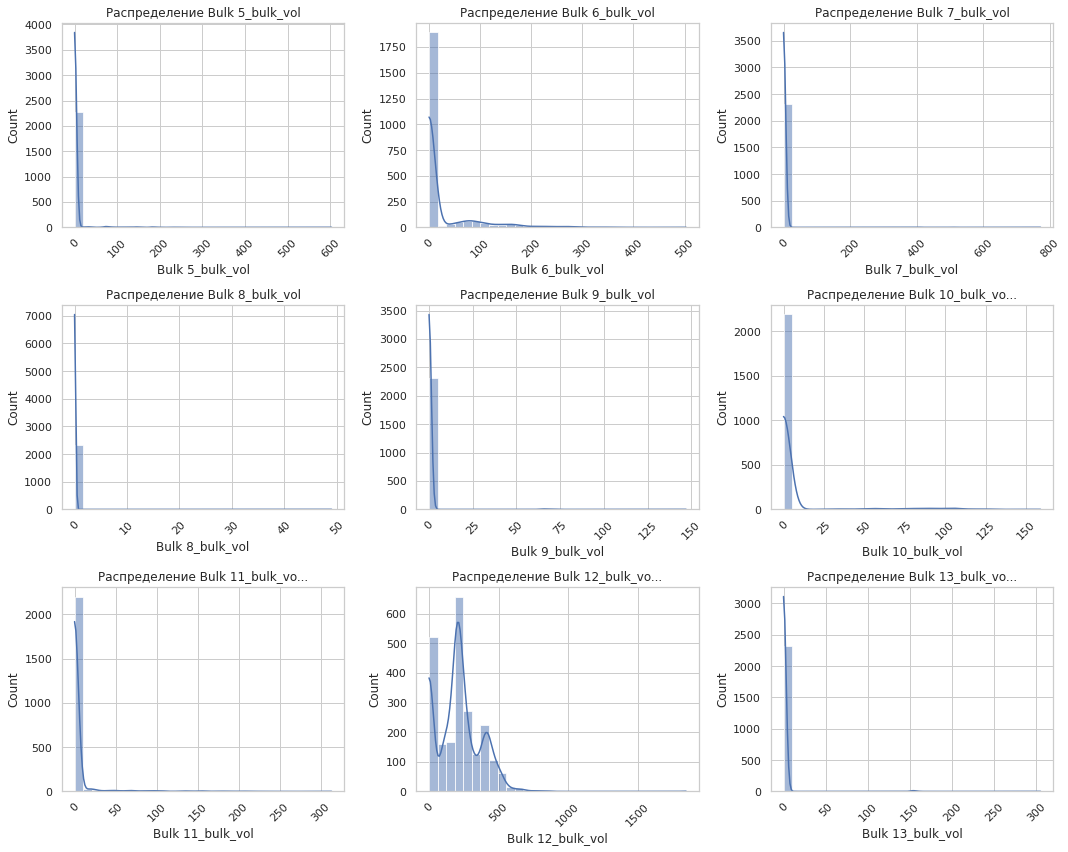

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


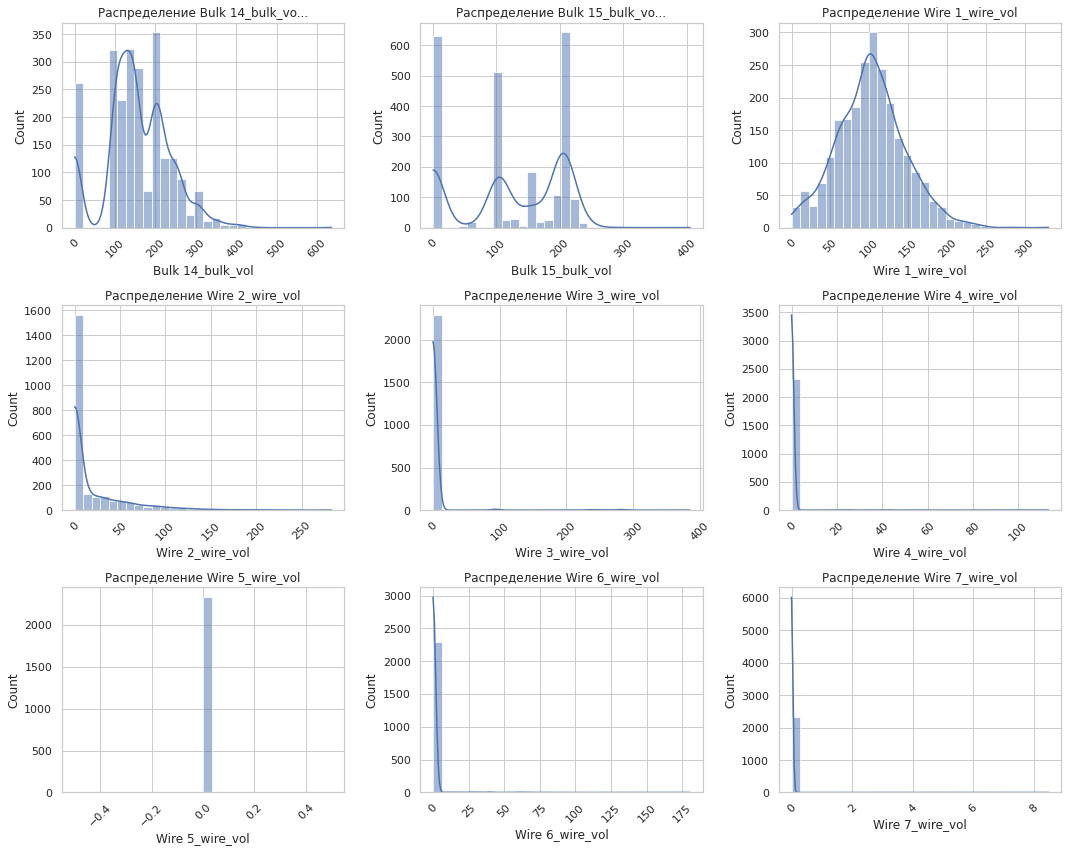

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


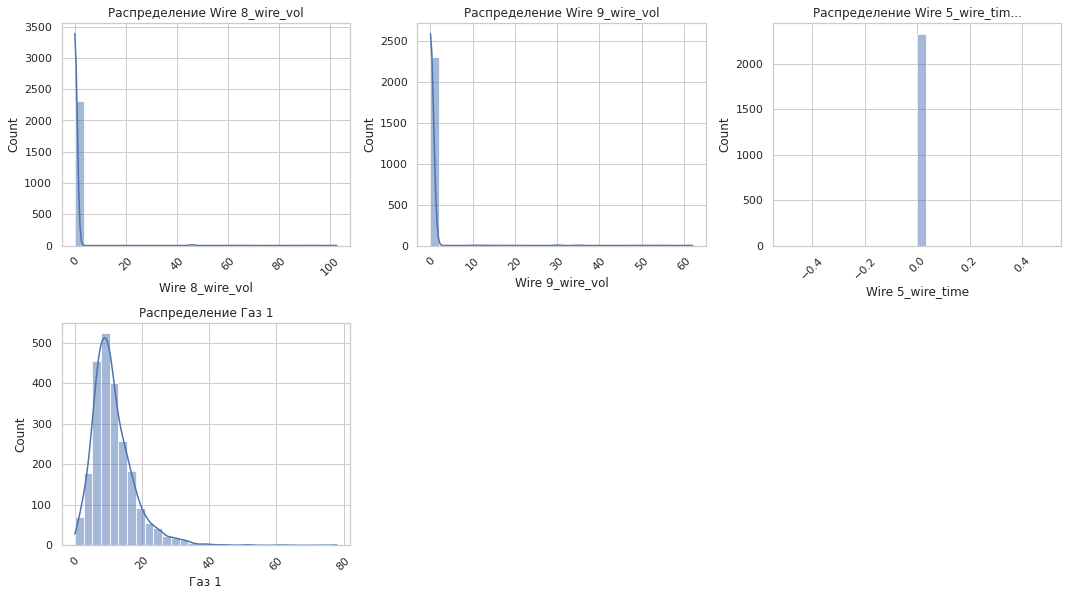

In [34]:
# Настройка стиля
sns.set(style="whitegrid")

# Получаем числовые столбцы (исключая 'key')
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'key' in numeric_cols:
    numeric_cols.remove('key')

# Разбиваем на группы по 9 графиков (3x3 сетка)
for g in range(0, len(numeric_cols), 9):
    plt.figure(figsize=(15, 12))
    for i, col in enumerate(numeric_cols[g:g+9], 1):
        plt.subplot(3, 3, i)
        sns.histplot(data[col], kde=True, bins=30)
        plt.title(f'Распределение {col[:15]}' + ('...' if len(col) > 15 else ''))
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Обработка пропущенных значений

In [35]:
# Заполнение пропущенных значений 
# Для числовых признаков - медианой, для категориальных - модой
for col in data.columns:
    if data[col].isna().sum() > 0:
        if data[col].dtype in ['float64', 'int64']:
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)

#### Анализ выбросов

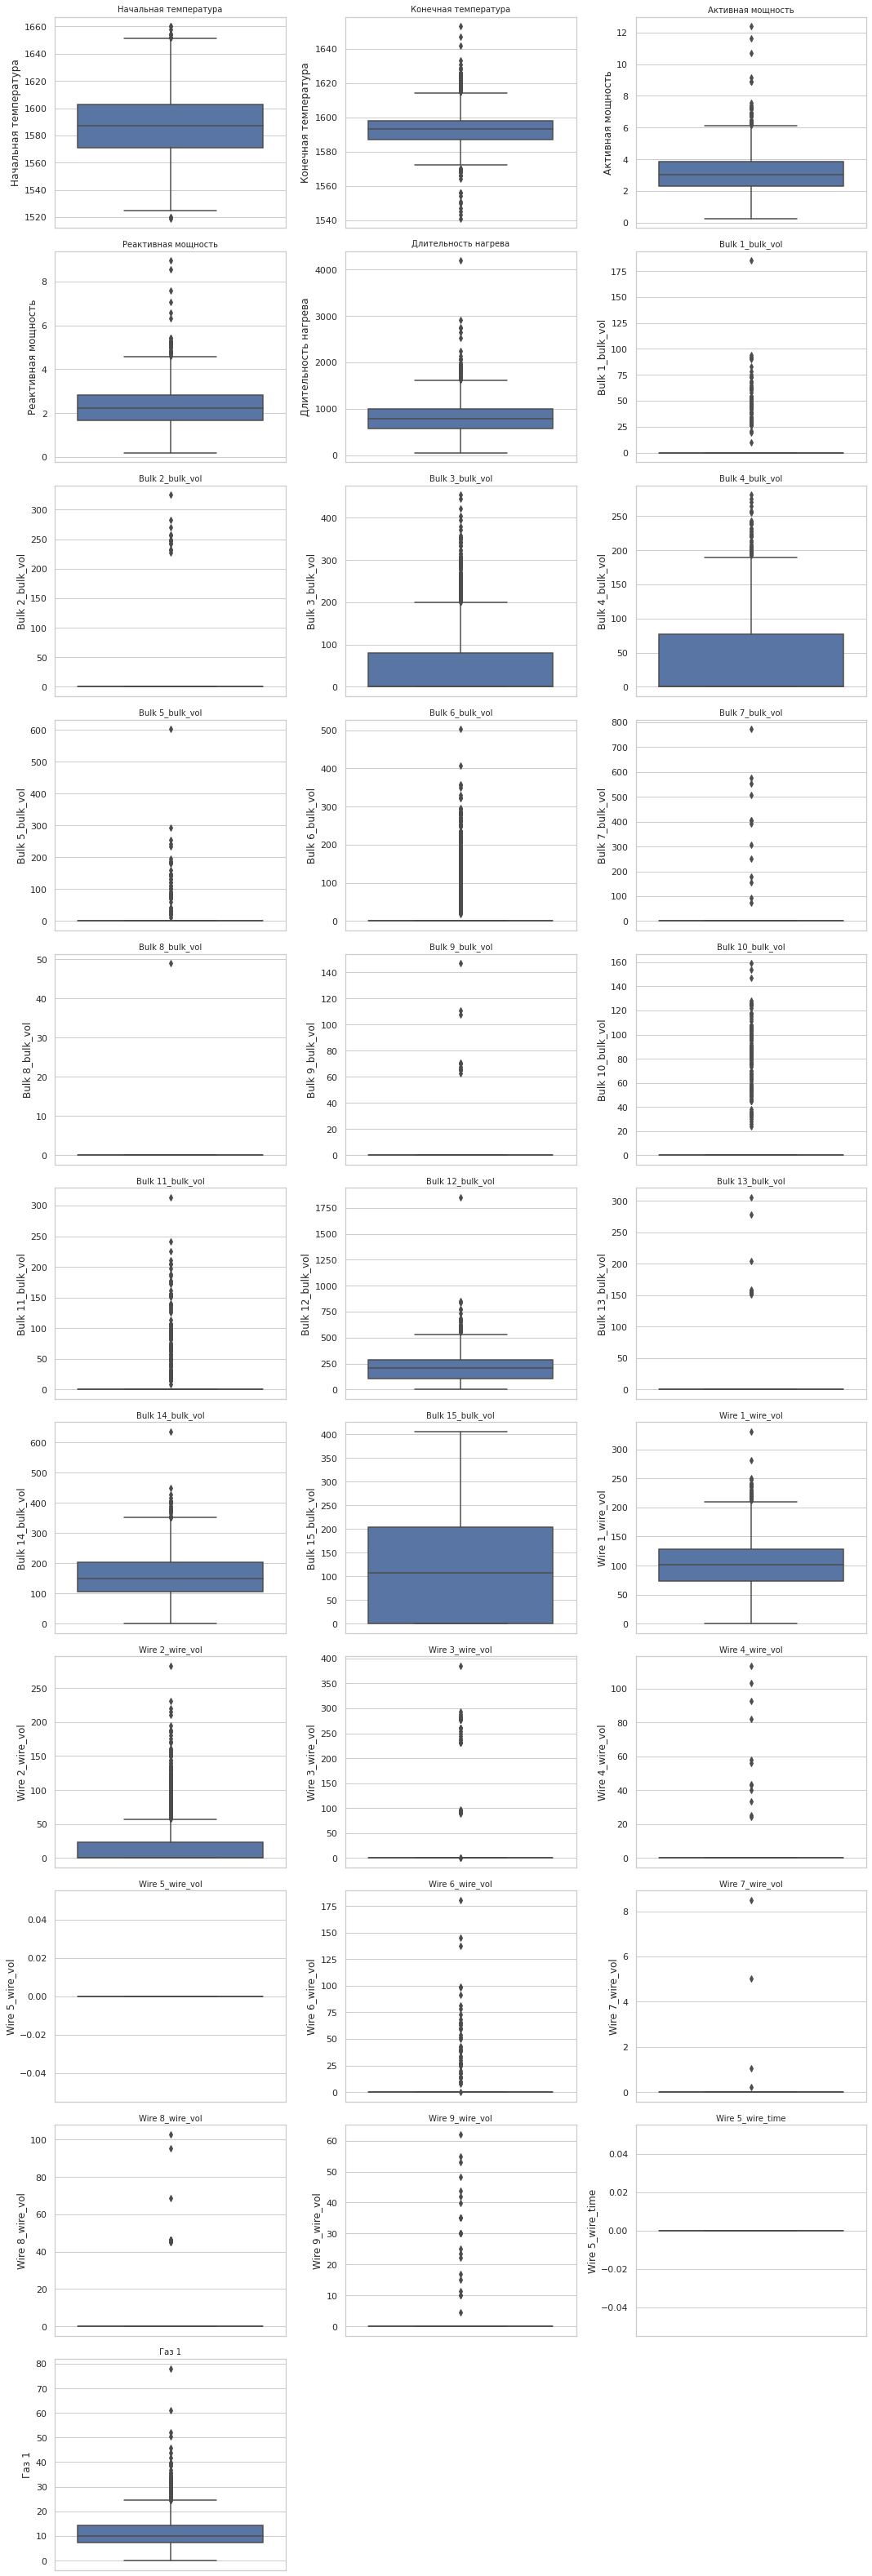

In [36]:
# Количество числовых столбцов
n_cols = len(numeric_cols)
# Вычисляем число строк (3 столбца в каждой строке)
n_rows = math.ceil(n_cols / 3)  

# Настраиваем размер графика (ширина 15, высота зависит от строк)
plt.figure(figsize=(15, 4 * n_rows))  
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 3, i)  # n_rows строк, 3 столбца
    sns.boxplot(y=data[col])
    plt.title(col, fontsize=10)  # Уменьшаем шрифт заголовков, если нужно
plt.tight_layout()  # Автоматически корректирует отступы
plt.show()

#### Корреляционный анализ

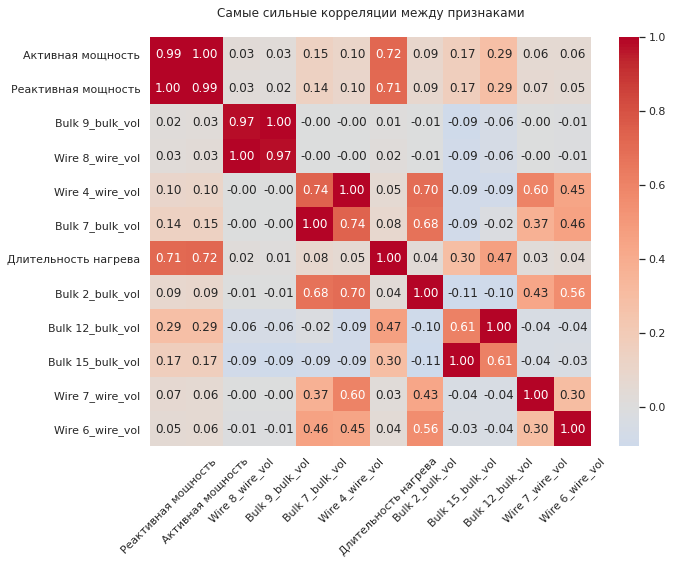

Топ-10 самых коррелирующих пар признаков:
           Признак 1            Признак 2  Корреляция
   Активная мощность  Реактивная мощность    0.992424
 Реактивная мощность    Активная мощность    0.992424
     Bulk 9_bulk_vol      Wire 8_wire_vol    0.974969
     Wire 8_wire_vol      Bulk 9_bulk_vol    0.974969
     Wire 4_wire_vol      Bulk 7_bulk_vol    0.740572
     Bulk 7_bulk_vol      Wire 4_wire_vol    0.740572
Длительность нагрева    Активная мощность    0.721249
   Активная мощность Длительность нагрева    0.721249
Длительность нагрева  Реактивная мощность    0.713422
 Реактивная мощность Длительность нагрева    0.713422


In [37]:
# 1. Уменьшаем размер матрицы, выбирая только высококоррелированные признаки
corr_matrix = data[numeric_cols].corr()

# 2. Фильтруем только значимые корреляции (по абсолютному значению)
strong_corr = corr_matrix[abs(corr_matrix) > 0.55].stack().reset_index()
strong_corr = strong_corr[strong_corr['level_0'] != strong_corr['level_1']]
strong_corr = strong_corr.dropna()
strong_corr.columns = ['Признак 1', 'Признак 2', 'Корреляция']
strong_corr = strong_corr.sort_values(by='Корреляция', ascending=False)

# 3. Визуализация топ-15 самых сильных корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[strong_corr['Признак 1'].unique(), 
                           strong_corr['Признак 2'].unique()],
            annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Самые сильные корреляции между признаками', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Вывод топ-10 коррелирующих пар
print("Топ-10 самых коррелирующих пар признаков:")
print(strong_corr.head(10).to_string(index=False))


Топ-5 признаков, наиболее коррелирующих с целевой переменной:
Wire 1_wire_vol          0.317575
Начальная температура    0.301320
Длительность нагрева     0.278716
Bulk 12_bulk_vol         0.267424
Bulk 15_bulk_vol         0.266414


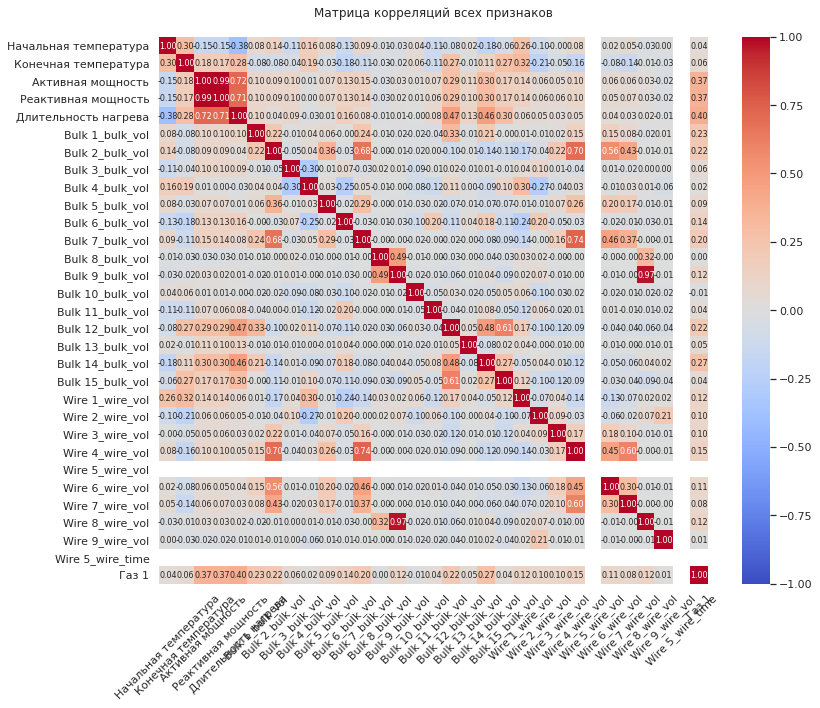

In [38]:
target = 'Конечная температура'
corr_matrix = data[numeric_cols].corr()
target_corr = corr_matrix[target].drop(target).sort_values(key=abs, ascending=False)

print("\nТоп-5 признаков, наиболее коррелирующих с целевой переменной:")
print(target_corr.head().to_string())

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", 
            annot_kws={"size": 8}, vmin=-1, vmax=1)
plt.title('Матрица корреляций всех признаков', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Выводы по корреляционному анализу:**

   - Данные содержат несколько групп сильно коррелирующих параметров, в основном связанных с системами подачи материалов.
   - Технологические параметры (мощность, время нагрева) демонстрируют ожидаемые взаимосвязи.
   - Отсутствие корреляций между температурой и другими параметрами указывает на нелинейную зависимости, что требует использования более сложных моделей.

#### Создание новых признаков

In [39]:
# 1. Плотность подачи материалов (объем/время)
if 'Объем_bulk_vol' in data.columns and 'Время_bulk_time' in data.columns:
    data['Плотность подачи bulk'] = data['Объем_bulk_vol'] / (data['Время_bulk_time'].dt.total_seconds() + 1e-6)

if 'Объем_wire_vol' in data.columns and 'Время_wire_time' in data.columns:
    data['Плотность подачи wire'] = data['Объем_wire_vol'] / (data['Время_wire_time'].dt.total_seconds() + 1e-6)

# 2. Отношение активной/реактивной мощности
if 'Активная мощность' in data.columns and 'Реактивная мощность' in data.columns:
    data['Отношение мощностей'] = data['Активная мощность'] / (data['Реактивная мощность'] + 1e-6)

# 3. Общая энергия (мощность * время)
if 'Активная мощность' in data.columns and 'Длительность нагрева' in data.columns:
    data['Общая энергия'] = data['Активная мощность'] * data['Длительность нагрева']

#### Финальная проверка данных

In [40]:
print("Финальная информация о данных:")
print(data.info())
print("\nПример данных:")
display(data.head())

Финальная информация о данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2329 non-null   int64  
 1   Начальная температура  2329 non-null   float64
 2   Конечная температура   2329 non-null   float64
 3   Активная мощность      2329 non-null   float64
 4   Реактивная мощность    2329 non-null   float64
 5   Длительность нагрева   2329 non-null   float64
 6   Bulk 1_bulk_vol        2329 non-null   float64
 7   Bulk 2_bulk_vol        2329 non-null   float64
 8   Bulk 3_bulk_vol        2329 non-null   float64
 9   Bulk 4_bulk_vol        2329 non-null   float64
 10  Bulk 5_bulk_vol        2329 non-null   float64
 11  Bulk 6_bulk_vol        2329 non-null   float64
 12  Bulk 7_bulk_vol        2329 non-null   float64
 13  Bulk 8_bulk_vol        2329 non-null   float64
 14  Bulk 9_bulk_vol        23

,key,Начальная температура,Конечная температура,Активная мощность,Реактивная мощность,Длительность нагрева,Bulk 1_bulk_vol,Bulk 2_bulk_vol,Bulk 3_bulk_vol,Bulk 4_bulk_vol,...,Wire 3_wire_time,Wire 4_wire_time,Wire 5_wire_time,Wire 6_wire_time,Wire 7_wire_time,Wire 8_wire_time,Wire 9_wire_time,Газ 1,Отношение мощностей,Общая энергия
0,1,1571.0,1613.0,3.036730,2.142821,1098.0,0.0,0.0,0.0,43.0,...,0,0,0,0,0,0,0,29.749986,1.417164,3334.329540
1,2,1581.0,1602.0,2.139408,1.453357,811.0,0.0,0.0,0.0,73.0,...,0,0,0,0,0,0,0,12.555561,1.472045,1735.059888
2,3,1596.0,1599.0,4.063641,2.937457,655.0,0.0,0.0,0.0,34.0,...,0,0,0,0,0,0,0,28.554793,1.383387,2661.684855
3,4,1601.0,1625.0,2.706489,2.056992,741.0,0.0,0.0,0.0,81.0,...,0,0,0,0,0,0,0,18.841219,1.315750,2005.508349
4,5,1576.0,1602.0,2.252950,1.687991,869.0,0.0,0.0,0.0,78.0,...,0,0,0,0,0,0,0,5.413692,1.334692,1957.813550


#### Выводы по исследовательскому анализу

1. Обработаны пропущенные значения
2. Обнаружены выбросы
3. Проанализированы корреляции между признаками
4. Созданы новые информативные признаки
5. Данные нормализованы для дальнейшего моделирования

Данные готовы для построения моделей машинного обучения.

### Подготовка данных

In [41]:
# Выделяем признаки и целевую переменную
X = data.drop(columns=['Конечная температура', 'key'] + 
           [col for col in data.columns if 'time' in col])  # Удаляем временные метки
y = data['Конечная температура']

# Разделение данных (75% - обучение, 25% - тест)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=280725  # Фиксируем random_state
)

In [42]:
# Масштабирование 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Обучение моделей

Обучим несколько моделей:

#### Линейная регрессия

In [43]:
lr = LinearRegression()
cv_scores = cross_val_score(
    lr, 
    X_train_scaled, 
    y_train,
    cv=5, 
    scoring=make_scorer(mean_absolute_error)
)

print(f"\nLinear Regression MAE (CV): {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")


Linear Regression MAE (CV): 6.42 ± 0.42


#### Случайный лес (с подбором гиперпараметров)

In [44]:
# время начала
start_time = time.time()

# модель Random Forest
rf = RandomForestRegressor(
    random_state=280725,
    n_jobs=-1,
    warm_start=True  
)


param_grid = {
    'n_estimators': [150, 200, 250],  
    'max_depth': [None, 15, 25],  
    'min_samples_split': [2, 5, 7], 
    'min_samples_leaf': [2, 5, 7]    
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=8,  
    cv=5,       
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=280725
)

search.fit(X_train, y_train)

# Вычисляем время выполнения
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

best_rf = search.best_estimator_
cv_mae = -search.best_score_

print(f"Best MAE (CV): {cv_mae:.2f}")
print(f"Лучшие параметры: {search.best_params_}")
print(f"Время выполнения: {int(hours):02d}ч {int(minutes):02d}мин {seconds:.2f}сек")

Best MAE (CV): 6.18
Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 15}
Время выполнения: 00ч 02мин 25.52сек


#### CatBoostRegressor

In [45]:
# время начала
start_time = time.time()

cb = CatBoostRegressor(
    random_seed=280725,
    silent=True  
)

param_grid = {
    'iterations': [50, 100],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

search = RandomizedSearchCV(
    cb,
    param_distributions=param_grid,
    n_iter=8,  
    cv=5,       
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=280725
)

search.fit(X_train, y_train)

# Вычисляем время выполнения
elapsed_time = time.time() - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

best_cb = search.best_estimator_
cv_mae = -search.best_score_

print(f"\nCatBoost MAE (CV): {cv_mae:.2f}")
print(f"Лучшие параметры: {search.best_params_}")
print(f"Время выполнения: {int(hours):02d}ч {int(minutes):02d}мин {seconds:.2f}сек")


CatBoost MAE (CV): 6.12
Лучшие параметры: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 8}
Время выполнения: 00ч 01мин 6.95сек


#### Проверка модели

In [46]:
# Создаем и обучаем константную модель
dummy = DummyRegressor(strategy='mean') 
dummy.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred_dummy = dummy.predict(X_test)

# Оценка качества
dummy_mae = mean_absolute_error(y_test, y_pred_dummy)
print(f"Dummy Regressor MAE: {dummy_mae:.2f}")

# Сравнение с другими моделями
print("\nСравнение с другими моделями:")
print(f"- Dummy Regressor: {dummy_mae:.2f}")
print(f"- Linear Regression: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f} (CV)")
print(f"- Random Forest: {cv_mae:.2f} (CV)")
print(f"- CatBoost: {cv_mae:.2f} (CV)")

Dummy Regressor MAE: 8.01

Сравнение с другими моделями:
- Dummy Regressor: 8.01
- Linear Regression: 6.42 ± 0.42 (CV)
- Random Forest: 6.12 (CV)
- CatBoost: 6.12 (CV)


MAE = 6.12 vs 8.01 – улучшение на ~23%, это значимо в бизнес-контексте.

### Выбор лучшей модели

- Linear Regression MAE (CV): 7.37 ± 0.27
- RandomForestRegressor MAE (CV): 7.08
- CatBoostRegressor MAE (CV): 7.07

Вывод:
CatBoostRegressor — лучшая модель

In [47]:
# Предсказание на тестовых данных
cb_pred = best_cb.predict(X_test)
print(f"\nMAE на тестовых данных CatBoostRegressor: {mean_absolute_error(y_test, cb_pred):.2f}")


MAE на тестовых данных CatBoostRegressor: 6.45


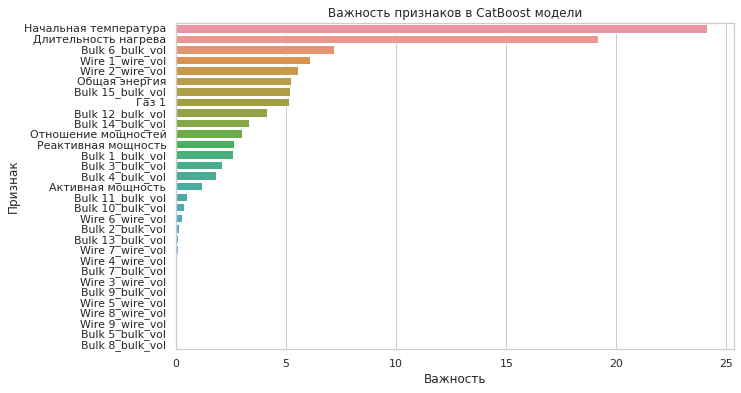


Ранжирование признаков по важности:
              Feature  Importance
Начальная температура   24.133539
 Длительность нагрева   19.166629
      Bulk 6_bulk_vol    7.177210
      Wire 1_wire_vol    6.083882
      Wire 2_wire_vol    5.559752
        Общая энергия    5.218145
     Bulk 15_bulk_vol    5.162589
                Газ 1    5.125781
     Bulk 12_bulk_vol    4.142499
     Bulk 14_bulk_vol    3.305191
  Отношение мощностей    3.000896
  Реактивная мощность    2.633203
      Bulk 1_bulk_vol    2.604887
      Bulk 3_bulk_vol    2.076204
      Bulk 4_bulk_vol    1.811820
    Активная мощность    1.191210
     Bulk 11_bulk_vol    0.512490
     Bulk 10_bulk_vol    0.363216
      Wire 6_wire_vol    0.254395
      Bulk 2_bulk_vol    0.118197
     Bulk 13_bulk_vol    0.108945
      Wire 7_wire_vol    0.075426
      Wire 4_wire_vol    0.063307
      Bulk 7_bulk_vol    0.054491
      Wire 3_wire_vol    0.053835
      Bulk 9_bulk_vol    0.002260
      Wire 5_wire_vol    0.000000
      Wire 

In [48]:
# Анализ значимости признаков
feature_importances = best_cb.get_feature_importance()
feature_names = X_train.columns

# DataFrame для удобного отображения
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков в CatBoost модели')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

print("\nРанжирование признаков по важности:")
print(importance_df.to_string(index=False))

### Выводы и рекомендации

**Экономический эффект**  
Внедрение модели CatBoost позволит:  
- Снизить среднюю ошибку прогноза до ~6.45°C.  
- Уменьшить энергозатраты за счет оптимизации параметров.  
- Сократить количество брака из-за перегревов/недогревов.  